# Spam Classification using yelp data

Import the neccesary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline
sns.set_style('white')
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
df = pd.read_csv('yelp.csv')

In [3]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [6]:
df.describe(include='all')

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,ntN85eu27C04nwyPa8IHtw,2011-03-28,ZCr1L3-T7VReMyf106piXA,NaN,Great service,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


In [7]:
df.isnull().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64

In [8]:
df['type'].value_counts()

review    10000
Name: type, dtype: int64

In [9]:
df['funny'].value_counts()

0     7013
1     1632
2      603
3      271
4      161
5       90
6       68
7       34
8       25
9       21
10      18
11      14
12      11
20       5
16       5
15       5
17       4
13       3
14       3
24       2
19       2
18       2
22       2
39       1
57       1
23       1
21       1
30       1
27       1
Name: funny, dtype: int64

In [10]:
df.groupby('stars').describe()

cool                                                useful            \
        count      mean       std  min  25%  50%  75%   max   count      mean   
stars                                                                           
1       749.0  0.576769  1.474759  0.0  0.0  0.0  1.0  17.0   749.0  1.604806   
2       927.0  0.719525  1.491182  0.0  0.0  0.0  1.0  14.0   927.0  1.563107   
3      1461.0  0.788501  1.602576  0.0  0.0  0.0  1.0  18.0  1461.0  1.306639   
4      3526.0  0.954623  2.034367  0.0  0.0  0.0  1.0  38.0  3526.0  1.395916   
5      3337.0  0.944261  2.484583  0.0  0.0  0.0  1.0  77.0  3337.0  1.381780   

       ...              funny                                                
       ...  75%   max   count      mean       std  min  25%  50%  75%   max  
stars  ...                                                                   
1      ...  2.0  20.0   749.0  1.056075  2.480309  0.0  0.0  0.0  1.0  30.0  
2      ...  2.0  17.0   927.0  0.875944  1.837553  0.0  0.0  0.0  1.0  20.0  
3      ...  2.0  19.0  1461.0  0.694730  1.643553  0.0  0.0  0.0  1.0  24.0  
4      ...  2.0  38.0  3526.0  0.670448  1.962417  0.0  0.0  0.0  1.0  57.0  
5      ...  2.0  76.0  3337.0  0.608631  1.815606  0.0  0.0  0.0  1.0  39.0  

[5 rows x 24 columns]

 "Stars" is what we need to predict
 So,let's explore stars

Lets create a new column to find the length of reviews

In [11]:
df['text length'] = df['text'].apply(len)

In [12]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


Let's create a plot of 5 different star rating with respect to their length using seaborn

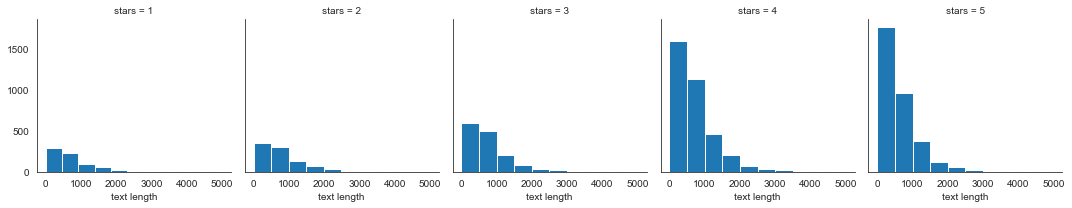

In [13]:
g = sns.FacetGrid(df,col='stars')
g.map(plt.hist,'text length')

:ets visualize total no. of stars in different lengths using plot


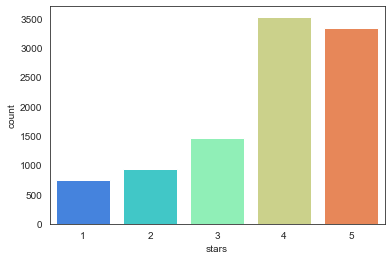

In [14]:
sns.countplot(x='stars',data=df,palette='rainbow')

Create a dataframe for finding correlation using the mean values of the numerical columns

In [15]:
new = df.groupby('stars').mean()
new

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [16]:
new.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


## Pre-Processing the data
Let's preprocess the text data before feeding to the model.
For that lets define a simple function to do it

In [17]:
def preprocess(mess):
    nopunc = [char for char in mess if char not in string.punctuation] # Remove punctuations
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] # remove stopwords

## Model Building
Let's build the model and test it

In [18]:
df_new = df[(df.stars==1) | (df.stars==5)]

In [19]:
X = df_new['text'] #input
y = df_new['stars'] #label

In [20]:
cv= CountVectorizer(analyzer=preprocess)

In [21]:
X = cv.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [23]:

nb = MultinomialNB()
nb.fit(X_train,y_train)

predictions = nb.predict(X_test)

In [24]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[157  71]
 [ 24 974]]


              precision    recall  f1-score   support

           1       0.87      0.69      0.77       228
           5       0.93      0.98      0.95       998

    accuracy                           0.92      1226
   macro avg       0.90      0.83      0.86      1226
weighted avg       0.92      0.92      0.92      1226

